In [1]:
from chan_modeling.archiving import MyThreads, clean, train, analyze, MySentences, get_single_vector
from chan_modeling.lda_modeling import *
from chan_modeling.functional_helpers import nth
from chan_modeling.parse_logs import get_perplexity_series_from_logs
from cofe_files.scripts.run_expansions import expand_archive
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.word2vec import FAST_VERSION
import pprint
from collections import Counter
from operator import itemgetter
from chan_modeling.visualization import plot_vector
%matplotlib inline
from IPython.display import IFrame
import plotly.graph_objs as go
import plotly
import itertools
import logging
logging.basicConfig(filename='gensim.log', format=u'%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pyromancer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/pyromancer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
train(50, 4, fname='test_model', dir_name='biz_archive')

In [2]:
analyze(50, 4, vector_fname='models/test_model_vectors', test_file_name='test_file.txt')

2018-08-07 06:01:20,855 : INFO : loading Word2VecKeyedVectors object from models/test_model_vectors
2018-08-07 06:01:21,127 : INFO : setting ignored attribute vectors_norm to None
2018-08-07 06:01:21,129 : INFO : loaded models/test_model_vectors
2018-08-07 06:01:21,134 : INFO : precomputing L2-norms of word weight vectors


2018-08-08 03:27:20,056 : INFO : loading Word2VecKeyedVectors object from models/test_model_vectors
2018-08-08 03:27:20,479 : INFO : setting ignored attribute vectors_norm to None
2018-08-08 03:27:20,480 : INFO : loaded models/test_model_vectors
2018-08-08 03:27:20,481 : INFO : precomputing L2-norms of word weight vectors


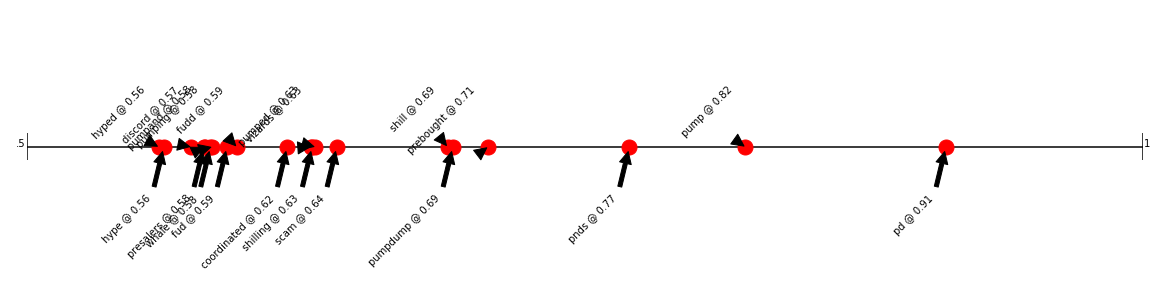

In [7]:
plot_vector('pnd', 'models/test_model_vectors')

In [2]:
threads = MyThreads('biz_archive')

In [3]:
doc_term_matrix, dictionary = prepare_dictionary(threads)

2018-08-11 05:17:07,525 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-11 05:17:46,999 : INFO : adding document #10000 to Dictionary(93571 unique tokens: ['065', '1', '40m', '60', 'actual']...)
2018-08-11 05:18:24,733 : INFO : adding document #20000 to Dictionary(156199 unique tokens: ['065', '1', '40m', '60', 'actual']...)
2018-08-11 05:18:40,759 : INFO : built Dictionary(183094 unique tokens: ['065', '1', '40m', '60', 'actual']...) from 24526 documents (total 3231880 corpus positions)


In [2]:
import umap

In [3]:
reducer = umap.UMAP()

In [4]:
class MyJoinedSentences():
    def __init__(self, unjoined_sentences):
        self.sents = unjoined_sentences
    
    def __iter__(self):
        for sent in self.sents:
            yield " ".join(sent)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
joined_threads = MyJoinedSentences(MySentences('biz_archive'))
short_threads = []
for i, sent in enumerate(joined_threads):
    if i > 10000:
        break
    short_threads.append(sent)


In [7]:
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(short_threads)


In [15]:
small = matrix[:10000, :10000].todense() + 1e-30

In [9]:
embedding = reducer.fit_transform(small)

/opt/conda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


In [10]:
embedding.shape

(10000, 2)

In [11]:
embedding[:, 0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [13]:
import matplotlib.pyplot as plt

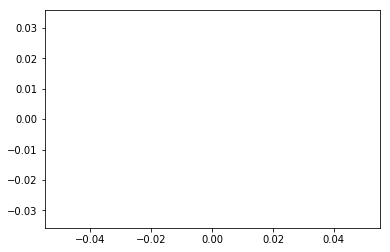

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')


In [ ]:
model = train_lda_model(100, dictionary, doc_term_matrix, 6, 10)

In [8]:
# model = LdaModel.load('models/ldamodel')

In [11]:
freqs = Counter()
get_highest_prob_topics = lambda x: x[1] > .1
first = itemgetter(0)
for thread in threads:
    tops = get_topics_for_document(thread, model, dictionary)
    topics = map(first, list(filter(get_highest_prob_topics, tops)))
    freqs[frozenset(topics)] += 1

In [13]:
second_element = itemgetter(1)
more_than_ten_documents = lambda x: x[1] > 10
more_than_one_topic = lambda x: len(x[0]) > 1
only_one_topic = lambda x: len(x[0]) == 1

key_topics = sorted(freqs.items(), key=second_element, reverse=True)
groups = list(filter(only_one_topic, key_topics))
groups = list(filter(more_than_ten_documents, groups))
pprint.pprint(groups)

[(frozenset({17}), 396),
 (frozenset({56}), 240),
 (frozenset({2}), 226),
 (frozenset({26}), 165),
 (frozenset({52}), 150),
 (frozenset({95}), 58),
 (frozenset({96}), 54),
 (frozenset({57}), 46),
 (frozenset({65}), 42),
 (frozenset({20}), 38),
 (frozenset({8}), 26),
 (frozenset({67}), 25),
 (frozenset({89}), 21),
 (frozenset({88}), 20),
 (frozenset({23}), 19),
 (frozenset({31}), 17),
 (frozenset({39}), 16),
 (frozenset({53}), 15),
 (frozenset({76}), 14),
 (frozenset({54}), 13),
 (frozenset({9}), 12),
 (frozenset({34}), 11),
 (frozenset({50}), 11),
 (frozenset({86}), 11),
 (frozenset({51}), 11),
 (frozenset({75}), 11)]


In [ ]:
group_sets, _ = zip(*groups)
for grp in group_sets:
    print("="*30)    
    print(list(grp))
    for topic in zip(grp, map(model.show_topic, grp)):
        pprint.pprint(list(topic))
        print('\n')    

In [ ]:
for topic in zip(topics, map(model.show_topic, topics)):
    print(topic)
    print('\n')

In [ ]:
model.top_topics(dictionary=dictionary, corpus=doc_term_matrix)

Word Counts
-----------
While I was reading about short-text topic modeling, I realized that I didn't actually have a good idea of how long the different documents were that I was dealing with. Most of the discussions of short text modeling focus on documents that are < 100 words, and I doubted that my documents were in that range. After a quick analysis of the word counts for each of the documents I was training on, I was surprised to find that the median length of a thread was 83 words. Almost all the documents fall into the < 500 word range, and ~1000 in total are more than 1000 words long. 

In [57]:
df = pd.read_table('counts.txt', names=['data'])

In [72]:
word_counts = df['data'].apply(lambda x: x.lstrip().split(' ')).apply(lambda x: int(x[0]))

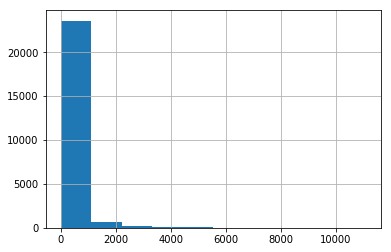

In [61]:
word_counts.hist()

In [71]:
word_counts.describe()

count    24527.000000
mean       236.305255
std        539.370150
min          0.000000
25%         29.000000
50%         83.000000
75%        222.000000
max      11079.000000
Name: data, dtype: float64

LDA on Longer Documents
-----------------------
Since the results of LDA on the whole corpus had been bad, I thought that maybe filtering on the documents that have more than some count $n$ words might improve the results. This is motivated by the idea that LDA, in order to recognize important word co occurance patterns between documents, requires documents of a certain minimum size to allow for sufficient co-occurances. Find below LDA models run and evaluated on for a few different $n$ thresholds.  

In [2]:
data_300 = prepare_dictionary_from_specific_files(all_files_directory='biz_archive', specific_files_text_file='300_word_threads.txt')

In [3]:
data_500 = prepare_dictionary_from_specific_files(all_files_directory='biz_archive', specific_files_text_file='500_word_threads.txt')

In [4]:
data_1000 = prepare_dictionary_from_specific_files(all_files_directory='biz_archive', specific_files_text_file='long_files.txt')

In [6]:
topic_counts = range(10, 101, 10)
data = [data_300, data_1000, data_500]
data_and_n_topics = itertools.product(topic_counts, data)

In [ ]:
for tup in data_and_n_topics:
    dtm = tup[1][0]
    dictionary = tup[1][1]
    train_lda_model(n_topics=tup[0], dictionary=dictionary, doc_term_matrix=dtm, n_passes=100, n_print_words=20)

In [13]:
three_hundred, five_hundred, one_thousand = get_perplexity_series_from_logs('gensim.log')

In [47]:
topics, _, perp = zip(*three_hundred)
topics2, _, perp2 = zip(*five_hundred)
topics3, _, perp3 = zip(*one_thousand)

In [73]:
file = plotly.offline.plot({
    "data": [go.Scatter(x=topics, y=perp, name='three hundred words'), 
             go.Scatter(x=topics2, y=perp2, name='five hundred words'), 
             go.Scatter(x=topics3, y=perp3, name='one thousand words')],
    "layout": go.Layout(title="number of topics vs log perplexity", 
                        xaxis=dict(title='number of topics'), 
                        yaxis=dict(title='log perplexity'))
})
IFrame(src=file[7:], height=500, width=800)

Results
--------
The results of training LDA on documents with higher word counts was not good. The above graph shows log perplexity vs number of topics for each of the three data sets that I used. This is the perplexity evaluated on the training set only, typically I would expect the score to decrease as the number of topics increases, because of overfitting on the training data. However, in this case, the perplexity increased, showing the the model doesn't fit well in general. This is likely because the ratio $\frac{topics}{documents}$ is too high, since filtering out shorter documents reduced the number of docuemnts in my dataset by between 80-95%.

Data Expansion
--------------
Since just using the naturally long documents didn't work well on LDA, I decided to artificially expand the shorter documents using a technique called CoFE. 

In [2]:
expand_archive('one_k_files')

entered create index at 1535777624.838694
excited create index after 4.702474594116211
entered create graph
num cores = 4
vocabulary size = 16137
initialized graph after 81.53978562355042
sorted vocabulary after 82.6507294178009
excited create graph after 88.38125610351562
entered readgraph index at 1535777718.242426
exited readgraph index after 0.11721634864807129
entered expand at 1535777718.3602562
exited expand after 11.273607969284058
